In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import math
import pyvista
import ufl
import basix
import dolfinx as df
import dolfinx.fem.petsc
from mpi4py import MPI
from dolfinx import fem

In [2]:
# define exact solution, return it (ufl and numpy representation)
def u_exact_np(x):
    U = -1
    theta = np.arctan2(x[1],x[0])

    d_psi_d_r = (U/((1/4)*(np.pi**2)-1))*((-1/4)*(np.pi**2)*(np.sin(theta))+((1/2)*(np.pi)*(theta)*(np.sin(theta)))+((theta)*(np.cos(theta))))
    d_psi_d_theta_overR = ((U)/((1/4)*(np.pi**2)-1)*(((-1/4)*(np.pi**2)*np.cos(theta))+((1/2)*(np.pi)*(np.sin(theta)))+((1/2)*(np.pi)*(theta)*(np.cos(theta)))+(np.cos(theta))-((theta)*(np.sin(theta)))))

    return np.array([(((np.cos(theta) * (d_psi_d_theta_overR))) + (np.sin(theta) * d_psi_d_r)), (((np.sin(theta) * (d_psi_d_theta_overR))) - (np.cos(theta) * d_psi_d_r))])

def u_exact(x):
    U = -1
    theta = ufl.atan2(x[1],x[0])

    d_psi_d_r = (U/((1/4)*(ufl.pi**2)-1))*((-1/4)*(ufl.pi**2)*(ufl.sin(theta))+((1/2)*(ufl.pi)*(theta)*(ufl.sin(theta)))+((theta)*(ufl.cos(theta))))
    d_psi_d_theta_overR = ((U)/((1/4)*(ufl.pi**2)-1)*(((-1/4)*(ufl.pi**2)*ufl.cos(theta))+((1/2)*(ufl.pi)*(ufl.sin(theta)))+((1/2)*(ufl.pi)*(theta)*(ufl.cos(theta)))+(ufl.cos(theta))-((theta)*(ufl.sin(theta)))))

    return ufl.as_vector([(((ufl.cos(theta) * (d_psi_d_theta_overR))) + (ufl.sin(theta) * d_psi_d_r)), (((ufl.sin(theta) * (d_psi_d_theta_overR))) - (ufl.cos(theta) * d_psi_d_r))])

In [3]:
# define a function which returns values for Dirichlet boundary condition (60)
def u_0(x):
    u = 1
    us = u * np.ones_like(x[0])
    zeroes = np.zeros_like(x[0])
    
    return np.array([us, zeroes])

In [4]:
def solve_batchelor(ne, p=1):
    # define the domain (unit square) of length and width ne, running in parallel
    domain = df.mesh.create_unit_square(MPI.COMM_WORLD, ne, ne)

    # define velocity and pressure element
    v_e = basix.ufl.element("Lagrange", domain.basix_cell(), p+1, shape=(domain.geometry.dim,))
    p_e = basix.ufl.element("Lagrange", domain.basix_cell(), p)

    # define mixed element
    vPe = basix.ufl.mixed_element([v_e, p_e])

    # define function space
    V = fem.functionspace(domain, vPe)

    # define Velocity and Pressure function space
    V_v, _ = V.sub(0).collapse()
    V_p, _ = V.sub(1).collapse()

    # define test functions
    v_t, p_t = ufl.TestFunctions(V)

    # define trial functions
    v_a, p_a = ufl.TrialFunctions(V)

    # define boundary value for Dirichlet boundary condition (59)
    def boundary_D_1(x):
        return np.isclose(x[0], 0)

    dofs_D_1 = fem.locate_dofs_geometrical((V.sub(0), V_v), boundary_D_1)
    u_bc1 = fem.Function(V_v)
    u_bc1.x.array[:] = 0
    bc1 = fem.dirichletbc(u_bc1, dofs_D_1, V.sub(0))

    # define boundary value for Dirichlet boundary condition (60)
    def boundary_D_2(x):
        return np.isclose(x[1], 0)

    dofs_D_2 = fem.locate_dofs_geometrical((V.sub(0), V_v), boundary_D_2)
    u_bc2 = fem.Function(V_v)
    u_bc2.interpolate(u_0)
    bc2 = fem.dirichletbc(u_bc2, dofs_D_2, V.sub(0))

    # define boundary value for Dirichlet boundary condition (61)
    def boundary_D_3(x):
        return np.logical_or(np.isclose(x[0], 1), np.isclose(x[1], 1))

    dofs_D_3 = fem.locate_dofs_geometrical((V.sub(0), V_v), boundary_D_3)
    u_bc3 = fem.Function(V_v)
    u_bc3.interpolate(u_exact_np)
    bc3 = fem.dirichletbc(u_bc3, dofs_D_3, V.sub(0))

    def boundary_D_4(x):
        return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))

    dofs_D_4 = fem.locate_dofs_geometrical((V.sub(1), V_p), boundary_D_4)
    u_bc4 = fem.Function(V_p)
    u_bc4.x.array[:] = 0
    bc4 = fem.dirichletbc(u_bc4, dofs_D_4, V.sub(1))

    # assemble weak form
    K = ufl.inner(ufl.sym(ufl.grad(v_t)), ufl.sym(ufl.grad(v_a))) * ufl.dx
    G = -ufl.div(v_t)*p_a*ufl.dx
    D = -p_t*ufl.div(v_a)*ufl.dx
    S = K + G + D

    zero = fem.Constant(domain, df.default_scalar_type(0.0))
    L = zero*p_t*ufl.dx

    # assemble problem solver and solve
    problem = df.fem.petsc.LinearProblem(S, L, bcs=[bc1, bc2, bc3, bc4], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
    uh = problem.solve()

    vh = uh.sub(0).collapse()

    return vh

In [5]:
def error(vh):
    x = ufl.SpatialCoordinate(vh.function_space.mesh)
    vex = u_exact(x)
    error_L2 = fem.assemble_scalar(fem.form((vh - vex)**2 * ufl.dx))
    error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

    xs = np.linspace(0, 1, 1001)  # third argument is arbitrary
    xgrid, ygrid = np.meshgrid(xs,xs)
    xyzs = np.stack((xgrid.flatten(), ygrid.flatten(), np.zeros_like(xgrid.flatten())), axis=1)
    cells = get_first_cells(xyzs, vh.function_space.mesh)
    vh_vals = vh.eval(xyzs, cells)[:,0]

    vex_vals = u_exact_np(xyzs.transpose())
    error_max = np.max(np.abs(vh_vals - vex_vals))
    error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
    
    return error_L2, error_max

In [6]:
# define a utility function to help with visualization
def get_first_cells(x, mesh):
    """
    Given a list of points and a mesh, return the first cells that each point lies in in the mesh.

    Arguments:
      * x    - coordinates of points
      * mesh - mesh

    Returns:
      * first_cells - a list of cells corresponding to each point in x
    """
    tree = df.geometry.bb_tree(mesh, mesh.geometry.dim)
    xl = x
    if len(x.shape)==1: xl = [x]
    first_cells = []
    for x0 in xl:
        cell_candidates = df.geometry.compute_collisions_points(tree, x0)
        cell = df.geometry.compute_colliding_cells(mesh, cell_candidates, x0).array
        assert len(cell) > 0
        first_cells.append(cell[0])
    return first_cells

In [7]:
def visualize(vh):
    pyvista.start_xvfb()

    pyvista_cells, cell_types, geometry = df.plot.vtk_mesh(vh.function_space)
    grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(vh)] = vh.x.array.real.reshape((geometry.shape[0], len(vh)))
    grid["u"] = values
    geom = pyvista.Arrow()
    glyphs = grid.glyph(orient="u", geom=geom, factor=0.09)

    plotter = pyvista.Plotter(window_size=[800,800])
    #plotter.add_mesh(grid, show_edges=True, show_scalar_bar=False, cmap='coolwarm')
    plotter.add_mesh(glyphs, cmap='coolwarm', show_scalar_bar=True)
    plotter.add_text("Batchelor Cornerflow Approximated Solution", position="upper_edge", font_size=14, color="black")
    plotter.view_xy()
    plotter.show()

In [8]:
def convergence():
    fig = pl.figure() # open plotting figures
    fig2 = pl.figure()
    
    ax = fig.gca()
    ax2 = fig2.gca()
    
    ps = [1, 2] # polynomial orders to try

    nelements = [10, 20, 40, 80] # resolutions to try

    test_passes = True # expected order of convergence flag

    for p in ps: # loop over polynomial orders
        errors_l2_a = [] # accumulate l2 errors
        errors_max = [] # accumulate max errors
        for ne in nelements: # loop over resolutions
            vh = solve_batchelor(ne, p) # solve 2D Poisson
            errorl2, errormax = error(vh) # evalute approximate solution error
            print('ne = ', ne, ', l2error = ', errorl2) # print and save l2 error
            print('ne = ', ne, ', max error = ', errormax) # print and save max error
            errors_l2_a.append(errorl2)
            errors_max.append(errormax)
        hs = 1./np.array(nelements)/p #work out order of convergence
        fit = np.polyfit(np.log(hs), np.log(errors_l2_a),1) # fit line to convergence data for l2 error
        fit2 = np.polyfit(np.log(hs), np.log(errors_max),1) # fit line to convergence data for max error
        print("***********  order of accuracy p={}, order={}".format(p,fit[0]))

        # log-log plot of the L2 error 
        ax.loglog(hs,errors_l2_a,'o-',label='p={}, order={:.2f}'.format(p,fit[0]))
        # log-log plot of the max error
        ax2.loglog(hs,errors_max,'o-',label='p={}, order={:.2f}'.format(p,fit2[0]))
    
        # Test if the order of convergence is as expected
        test_passes = test_passes and abs(fit[0]-1) < 0.1

    # Tidy up the plot
    %matplotlib inline
    ax.set_xlabel('h')
    ax.set_ylabel('||e||_2')
    ax.grid()
    ax.set_title('Convergence: L2 Error')
    ax.legend()
    fig.savefig('batchelor_cornerflow.pdf')
    fig.show()
    
    ax2.set_xlabel('h')
    ax2.set_ylabel('||e||_max')
    ax2.grid()
    ax2.set_title('Convergence: Max Error')
    ax2.legend()
    fig2.show()

    print("***********  convergence figure in batchelor_cornerflow.pdf")
    # Check if we passed the test
    assert(test_passes)

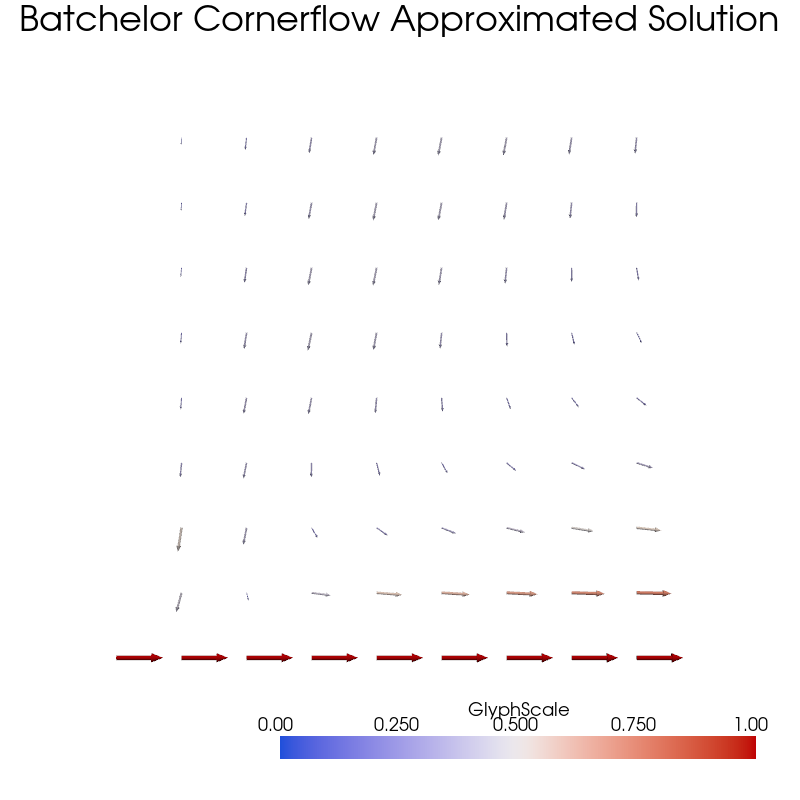

L2 error, max error:
(0.05477352752133853, 1.3490440178563678)
ne =  10 , l2error =  0.02192108947166191
ne =  10 , max error =  1.3114292378617005
ne =  20 , l2error =  0.010960435556187129
ne =  20 , max error =  1.2739060444616
ne =  40 , l2error =  0.00548021113521156
ne =  40 , max error =  1.2089284904394972
ne =  80 , l2error =  0.002740105138877033
ne =  80 , max error =  1.0845374436321542
***********  order of accuracy p=1, order=1.0000050785209509
ne =  10 , l2error =  0.012877716729227042
ne =  10 , max error =  1.2691833667367596
ne =  20 , l2error =  0.006438858695194861
ne =  20 , max error =  1.2002426704829796
ne =  40 , l2error =  0.0032194293512679472
ne =  40 , max error =  1.0700358841023303
ne =  80 , l2error =  0.001609714675634614
ne =  80 , max error =  1.0000000000000004
***********  order of accuracy p=2, order=0.999999977120808
***********  convergence figure in batchelor_cornerflow.pdf


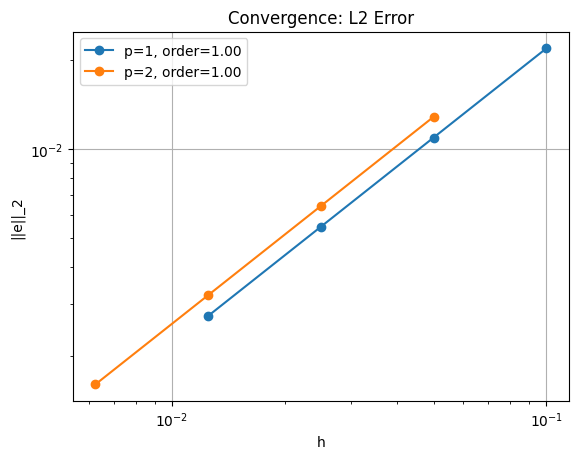

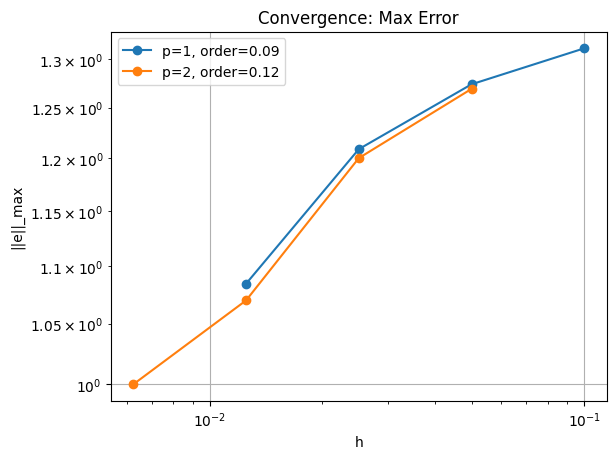

In [9]:
# main
solution = solve_batchelor(4)
visualize(solution)
errors = error(solution)
print("L2 error, max error:")
print(errors)
convergence()